## Decisions logic

Game choice logic:
- Somewhat nieche games with an assumed older audience, so reviews will be more constructive and 
  objective as oposed to having jokes or other off topic content;
- A decent number of reviews and a good balance between positive and negative with little varience overtime.

|      GAME       |  APPID  | POSITIVE REVIEWS | NEGATIVE REVIEWS | PERCENT | TOTAL |
|      :---       |   ---:  |      :---:       |       :---:      |  :---:  | :---: |
| F1 Manager 2024 | 2591280 |       1652       |        830       |   65%   | 2482  |
| Trials Fusion   |  245490 |       1550       |        734       |   66%   | 2284  |

As of 2024/10/12, no filters

---

How does Steam rating work?

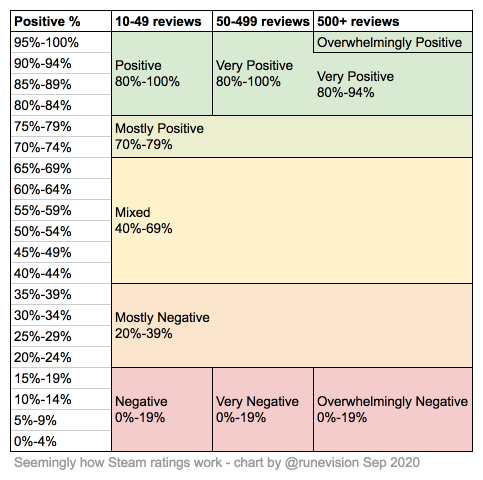

---

Why leave the filter_offtopic_activity on:  
From [Steam docs](https://partner.steamgames.com/doc/store/reviews#ReviewBombing) on "Review Bombing":

> In all examples, the surge of volume and sentiment will calm down after a few days.
> The reviews during that period will be bucketed by Steam and identified as such by your customers.
> In the case of **off-topic bombs, those reviews will not contribute to your overall score**.
>
> The majority of reviews associated with bombs aren't typically marked as helpful.
> Once the campaign is over, it's less likely that they will be surfaced in your review feed.
> *We also haven't seen a correlation between review bombs and purchasing behavior.*


## Imports and downloads


In [285]:
import io
import logging
import re
import urllib.parse
from string import punctuation
from typing import Any
import datetime

from wordcloud import WordCloud
from sklearn.metrics import ConfusionMatrixDisplay
from nltk import ngrams, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import streamlit as st
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.util import is_cjk
from rich import print as rprint
from rich.logging import RichHandler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
_ = nltk.download("punkt_tab")
_ = nltk.download("wordnet")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Rodrigo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rodrigo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data acquisition and formatting

### Logger e Misc


In [3]:
logger: logging.Logger = logging.getLogger(__name__)
# log_console_handler = logging.StreamHandler()
# log_formater = logging.Formatter(
#     "%(asctime)s - %(name)s - %(levelname)s - %(message)s", datefmt="%Y-%m-%d %H:%M"
# )

# log_console_handler.setFormatter(log_formater)
# logger.addHandler(log_console_handler)
logger.addHandler(RichHandler(rich_tracebacks=True))
logger.setLevel(logging.INFO)

In [307]:
pd.options.styler.format.precision = 3

### Game Class

In [5]:
class Game:
    """
    A class for working with Steam reviews.

    Attributes:
        name (str): The name of the game.
        appid (str): The Steam App ID of the game.
        params (dict[str, str]): The parameters for the Steam API call, in sorted order.
        cursor (dict[str, str]): The cursor parameter, as a dict.
        url (str): The URL for the Steam API call, with the parameters encoded in sorted order, excluding the cursor.
    """

    _root_url: str = "https://store.steampowered.com/appreviews/"

    _base_params: dict[str, str] = {
        "filter": "updated",  # all (default), recent, updated. all always returns --> can return duplicates
        "language": "english",  # english, brazilian, all ...
        # "day_range": "365",  # range from now to n days ago to look for helpful reviews. Only applicable for the "all" filter. Maximum value is 365.
        # "cursor": "*",  # Initial value
        # "review_type": "all",  # all (default), positive, negative
        "purchase_type": "all",  # all, non_steam_purchase, steam (default)
        "num_per_page": "100",  # Max=100, default=20
        # "filter_offtopic_activity": "1",  # aka. "Review Bombing". 0 to include, by default filter
    }  # https://partner.steamgames.com/doc/store/getreviews

    def __init__(
        self, name: str, appid: str, params: dict[str, str] = {}, cursor_val: str = "*"
    ):
        self._name: str = name.strip()
        self._appid: str = appid.strip()
        self._params: dict[str, str] = dict(
            sorted({**self._base_params, **params}.items())
        )
        self._cursor: dict[str, str] = {"cursor": f"{cursor_val}"}
        self._clear_url: str = f"{self._root_url}{self._appid}?json=1"
        self.url: str = f"{self._clear_url}&{urllib.parse.urlencode(self._params)}"
        logger.debug(self)

    @property
    def name(self) -> str:
        """The name of the game."""
        return self._name

    @property
    def appid(self) -> str:
        """The Steam App ID of the game as a string."""
        return self._appid

    @property
    def cursor(self) -> dict[str, str]:
        """The cursor parameter, as a dict."""
        return self._cursor

    @cursor.setter
    def cursor(self, cursor_value: str) -> None:
        """Set the VALUE of the cursor key in the dictionary object of the same name (cursor).

        Set value to '' if value can't be converted to string."""

        try:
            self._cursor["cursor"] = str(cursor_value)
        except (TypeError, ValueError):
            logger.exception(
                "Failed conversion to string of cursor value provided ('%s'), defaulting to ''",
                cursor_value,
            )
            self._cursor["cursor"] = ""

    def get_params(self) -> dict[str, str]:
        """Returns the params dictionary."""
        return self._params

    def update_params(self, new_params: dict[str, str]) -> None:
        """Update params. If keys match values from new_params will override original params's,
        else, new (key, value) pairs will be added.

        The new dictionary will be sorted by key and the url will be changed to incorporate the new parameters"""

        self._params = dict(sorted({**self._params, **new_params}.items()))
        self.url = f"{self._clear_url}&{urllib.parse.urlencode(self._params)}"

    def set_params(self, new_params: dict[str, str]) -> None:
        """Overrides original params with new_params.

        The new dictionary will be sorted by key and the url will be changed to incorporate the new parameters"""

        self._params = dict(sorted(new_params.items()))
        self.url = f"{self._clear_url}&{urllib.parse.urlencode(self._params)}"

    def __repr__(self) -> str:
        return f"Game(name='{self._name}', appid={self._appid},\nparams={self._params},\ncursor={self._cursor},\nurl={self.url})"


### Requests code


In [6]:
def check_json_header(
    session: requests.Session,
    url: str,
    cursor: dict[str, str] = {"cursor": "*"},
    timeout: int = 6,
) -> bool:
    """Checks if the response header contains "json" in its Content-Type.

    Returns True if it does contain.
    If the response status code is an error it raises an exception.
    """
    try:
        r: requests.Response = session.head(url, params=cursor, timeout=timeout)
        r.raise_for_status()
        if r.status_code != 200:
            logger.warning(
                "Got code <[%s]: %s> when checking header for URL: %s",
                r.status_code,
                r.reason,
                r.url,
            )
        return "json" in r.headers["Content-Type"]
    except KeyError as e:
        logger.error(
            "KeyError: %s\nWhen accessing the header content from url= %s", e, url
        )
    except requests.RequestException as e:
        logger.error(
            "%s: %s\nWhen trying to GET header from url= %s", type(e).__name__, e, url
        )
    return False


def get_reviews(
    session: requests.Session,
    url: str,
    cursor: dict[str, str] = {"cursor": "*"},
    timeout: int = 6,
) -> requests.Response:
    """Sends a GET request.

    If the response status code is not an error it returns the response else it raises an exception.
    """
    try:
        r: requests.Response = session.get(url, params=cursor, timeout=timeout)
        r.raise_for_status()
        return r
    except requests.RequestException as e:
        logger.error(
            "%s: %s\nWhen trying to GET reviews from url= %s\n%s",
            type(e).__name__,
            e,
            url,
            cursor,
        )
        raise e from None


def content_to_json(r: requests.Response) -> dict[str, Any]:
    """Converts the response content to a JSON object.

    Returns a dict representation of the JSON or raises an exception if it fails."""
    try:
        return r.json()
    except requests.JSONDecodeError as e:
        logger.error(
            "JSONDecodeError: %s\nWhen trying to convert response to json from url= %s",
            e,
            r.url,
        )
        raise e from None


def reviews_requests_task(
    url: str,
    max_reviews: int = 10000,
    timeout: int = 6,
    cursor_val: str = "*",
    **kwargs,
) -> tuple[list[dict[str, Any]], dict[str, Any]]:
    """reviews_task Get all the reviews for a Steam game quering the public Steam API.

    Args:
        url (str): URL to the Steam API with the query parameters, except for cursor.
        max_reviews (int, optional): Maximum number of reviews to return. Defaults to 10000.
        timeout (int, optional): Time in seconds for the requests to time out. Defaults to 6.
        cursor_val (str, optional): Cursor value  to get the next batch. Defaults to '*'.
        **kwargs: Any other keyword arguments.

    Returns:
        tuple[list[dict[str, Any]], dict[str, Any]]: A tuple with a List of reviews, and the query summary.
    """

    # Simple debug hook
    def debug_responses(r: requests.Response, *args, **kwargs) -> None:
        """Simple debugging function to log the response code and url for every request response.
        Intened to be used as a hook."""
        logger.debug("Code= <[%s]: %s> \t%s\n", r.status_code, r.reason, r.url)

    # Create the cursor object
    cursor: dict[str, str] = {"cursor": cursor_val}

    # Create empty list of reviews
    reviews: list[dict[str, Any]] = []
    # Create empty query summary
    qs: dict[str, Any] = {}

    # Create a requests Session
    with requests.Session() as s:
        # Add debug hook
        s.hooks["response"].append(debug_responses)

        # Get the header and check if API returns "json"
        if not check_json_header(s, url, cursor, timeout):
            return (reviews, qs)

        # Get the query summary and first batch of reviews
        try:
            r: requests.Response = get_reviews(s, url, cursor, timeout)
        except requests.RequestException:
            return (reviews, qs)

        # Convert response content to json
        try:
            j: dict[str, Any] = content_to_json(r)
        except requests.JSONDecodeError:
            return (reviews, qs)

        # Consume the first response and log query summary
        try:
            qs = j.pop("query_summary")
            logger.info(
                "GameID= %7s\n---------------\nPositive= %5s\nNegative= %5s\nReviews= %6s\n---------------\nRating= %7s",
                url.split("?")[0].split("/")[-1],
                qs["total_positive"],
                qs["total_negative"],
                qs["total_reviews"],
                qs["review_score_desc"],
            )

            # Define the number reviews to get based on max_reviews and available reviews
            max_reviews = (
                max_reviews
                if max_reviews < int(qs["total_reviews"])
                else int(qs["total_reviews"])
            )

            # Extract number of reviews per request
            num_revs: int = int(qs["num_reviews"])

            # Define number of GET requests to make
            num_req: int = int(np.ceil((max_reviews - num_revs) / num_revs))

            # Extract the cursor to get the next batch
            cursor["cursor"] = j.pop("cursor")

            # Extract the list of reviews
            reviews.extend((j.pop("reviews")))

            # Returns the list of reviews and the query summary if there are no more reviews to get
            if num_req <= 0:
                return (reviews, qs)

        except (KeyError, ValueError, TypeError) as e:
            logger.error(
                "%s: %s\nWhen accessing the json content 'query_summary' from url= %s",
                type(e).__name__,
                e,
                r.url,
            )
            return (reviews, qs)

        # Get the rest of the reviews
        logger.info(
            "Performing %3d GET requests to get %5d reviews...", num_req, max_reviews
        )
        for i in range(num_req):
            try:
                # Get the next batch of reviews
                r = get_reviews(s, url, cursor, timeout)
                # Convert to json
                j = content_to_json(r)
                # Update cursor
                cursor["cursor"] = j.pop("cursor")
                # Extend list of reviews
                reviews.extend((j.pop("reviews")))

            except (requests.RequestException, KeyError) as e:
                logger.error(
                    "%s: %s\nIn (%3d/%3d) iteration when trying to get remaining reviews.\nGot (%5d/%5d)",
                    type(e).__name__,
                    e,
                    (i + 1),
                    num_req,
                    len(reviews),
                    max_reviews,
                )
                return (reviews, qs)

    # Return the list of reviews and query summary
    logger.info("Success! Acquired %5d reviews.", len(reviews))
    return (reviews, qs)


### Dataframe factory

In [7]:
# Define empty dataframe
df_summary: pd.DataFrame = pd.DataFrame()


def build_df_summary(
    df_summary: pd.DataFrame, query_summary: dict[str, Any], game_name: str, **kwargs
) -> pd.DataFrame:
    """Build summary dataframe."""

    df_temp: pd.DataFrame = pd.DataFrame(query_summary, index=[game_name]).drop(
        columns="num_reviews"
    )
    df_temp["percent"] = (
        df_temp["total_positive"] * 100 / df_temp["total_reviews"]
    ).round(1)
    df_summary = (
        pd.concat([df_summary, df_temp])
        .reset_index(names="Game")
        .drop_duplicates(subset=["Game"], keep="last")
        .set_index("Game")
        .sort_index(key=lambda x: x.str.lower())
    )
    df_summary.columns.name = "Games Summary"
    return df_summary


def unix_to_datetime(df: pd.DataFrame, cols: list[str]) -> None:
    """Convert unix timestamp to datetime."""
    df[cols] = df[cols].apply(lambda x: pd.to_datetime(x, unit="s"))


def datetime_to_unix(df: pd.DataFrame, cols: list[str]) -> None:
    """Convert datetime to unix timestamp."""
    df[cols] = df[cols].apply(lambda x: x.timestamp())


def min_to_hours(df: pd.DataFrame, cols: list[str]) -> None:
    """Convert minutes to hours."""
    df[cols] = df[cols].apply(lambda x: (x / 60.0).round(1))


def build_df(
    reviews_list: list[dict[str, Any]], game_name: str, **kwargs
) -> pd.DataFrame:
    """Create dataframe from reviews list."""

    # List of unwanted columns
    unwanted_cols: list[str] = [
        "recommendationid",
        "language",
        "timestamp_created",
        # "hidden_in_steam_china",
        # "steam_china_location",
        "primarily_steam_deck",
        "author_steamid",
        "author_deck_playtime_at_review",
    ]

    # List of datetime columns
    datetime_cols: list[str] = ["timestamp_updated", "author_last_played"]

    # List of timedelta columns
    timedelta_cols: list[str] = [
        "author_playtime_last_two_weeks",
        "author_playtime_forever",
        "author_playtime_at_review",
    ]

    # Create dataframe and drop unwanted columns
    df: pd.DataFrame = pd.json_normalize(data=reviews_list, sep="_").drop(
        columns=unwanted_cols
    )

    # Drop columns with constant value
    # df.drop(columns=df.nunique()[df.nunique() == 1].index.tolist(), inplace=True)

    # Convert unix timestamps to datetime
    unix_to_datetime(df, datetime_cols)

    # Convert min to hours
    min_to_hours(df, timedelta_cols)

    # Convert weighted_vote_score to numeric (float)
    df.weighted_vote_score = pd.to_numeric(df.weighted_vote_score)

    # Convert review to string
    df.review = df.review.astype("string")

    # Name the column header of dataframe
    df.columns.name = game_name

    # Log dataframe info
    buffer = io.StringIO()
    df.info(buf=buffer)
    logger.debug(buffer.getvalue())
    del buffer

    # Return the dataframe
    return df


### Task to GET data and build dataframes


In [8]:
def reviews_df_task(
    url: str, game_name: str, **kwargs
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """reviews_df_task Queries the Steam API and builds the reviews DataFrame and the summary DataFrame

    Note: Check https://partner.steamgames.com/doc/store/getreviews for dataframe legend

    Args:
        url (str): URL with params, except cursor,to query for reviews
        game_name (str): Name of the game to query
        **kwargs: Keyword arguments to pass underlying functions

    Returns:
        tuple[Reviews: pd.DataFrame, Summary: pd.DataFrame]: The DataFrame of reviews from the game and the summary DataFrame
    """
    global df_summary
    reviews_list, query_summary = reviews_requests_task(url, **kwargs)
    try:
        df_summary = build_df_summary(df_summary, query_summary, game_name, **kwargs)  # pyright: ignore[reportUnboundVariable]
    except NameError:
        df_summary = pd.DataFrame()
        build_df_summary(df_summary, query_summary, game_name, **kwargs)

    df: pd.DataFrame = build_df(reviews_list, game_name, **kwargs)
    logger.info("Done! Reviews acquired and DataFrames build for game '%s'", game_name)
    display(df_summary.head())
    rprint(
        f"DataFrame has for game '{df.columns.name}' has:\nReviews={df.shape[0]} and Columns={df.shape[1]}"
    )
    display(df.sample(3))
    return (df, df_summary)


### Games and DataFrames

In [9]:
g1 = Game("F1 Manager 2024", "2591280")
g2 = Game("Trials Fusion", "245490")

#### Game 1

In [10]:
df1_get, df_summary = reviews_df_task(g1.url, g1.name)

[11/06/24 01:31:33] INFO     GameID= 2591280                                                       ]8;id=395763;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_10808\464236683.py\464236683.py]8;;\:]8;id=319954;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_10808\464236683.py#132\132]8;;\
                             ---------------                                                                       
                             Positive=   798                                                                       
                             Negative=   439                                                                       
                             Reviews=   1237                                                                       
                             ---------------                                                                       
                             Rating=   Mixed                                                                       

                    INFO     Performing  12 GET requests to get  1237 reviews...                   ]8;id=744722;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_10808\464236683.py\464236683.py]8;;\:]8;id=797966;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_10808\464236683.py#174\174]8;;\

[11/06/24 01:31:36] INFO     Success! Acquired  1237 reviews.                                      ]8;id=315140;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_10808\464236683.py\464236683.py]8;;\:]8;id=791951;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_10808\464236683.py#201\201]8;;\

[11/06/24 01:31:37] INFO     Done! Reviews acquired and DataFrames build for game 'F1 Manager      ]8;id=640194;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_10808\3884985259.py\3884985259.py]8;;\:]8;id=653;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_10808\3884985259.py#25\25]8;;\
                             2024'                                                                                 

Games Summary,review_score,review_score_desc,total_positive,total_negative,total_reviews,percent
Game,,,,,,
F1 Manager 2024,5,Mixed,798,439,1237,64.5


DataFrame has for game 'F1 Manager 2024' has:
Reviews=1237 and Columns=16

F1 Manager 2024,review,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played
516,it is best manager game,2024-08-08 08:02:07,True,2,4,0.512563,0,False,False,False,4,2,49.1,14.3,12.6,2024-11-05 20:53:12
1038,Game is unfinished and certain parts of it are...,2024-07-25 02:10:54,False,0,1,0.543568,0,True,False,False,315,123,6.7,0.0,2.3,2024-07-25 02:07:28
709,Better than skibidi toilet,2024-07-31 11:45:42,True,0,0,0.474138,2,True,False,False,0,4,85.4,8.7,25.8,2024-10-31 22:22:42


#### Game 2

In [11]:
df2_get, df_summary = reviews_df_task(g2.url, g2.name)

                    INFO     GameID=  245490                                                       ]8;id=77486;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_10808\464236683.py\464236683.py]8;;\:]8;id=890536;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_10808\464236683.py#132\132]8;;\
                             ---------------                                                                       
                             Positive=   950                                                                       
                             Negative=   503                                                                       
                             Reviews=   1453                                                                       
                             ---------------                                                                       
                             Rating=   Mixed                                                                       

                    INFO     Performing  14 GET requests to get  1453 reviews...                   ]8;id=196072;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_10808\464236683.py\464236683.py]8;;\:]8;id=453117;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_10808\464236683.py#174\174]8;;\

[11/06/24 01:31:42] INFO     Success! Acquired  1453 reviews.                                      ]8;id=967213;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_10808\464236683.py\464236683.py]8;;\:]8;id=901143;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_10808\464236683.py#201\201]8;;\

                    INFO     Done! Reviews acquired and DataFrames build for game 'Trials Fusion'  ]8;id=333722;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_10808\3884985259.py\3884985259.py]8;;\:]8;id=316804;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_10808\3884985259.py#25\25]8;;\

Games Summary,review_score,review_score_desc,total_positive,total_negative,total_reviews,percent
Game,,,,,,
F1 Manager 2024,5,Mixed,798,439,1237,64.5
Trials Fusion,5,Mixed,950,503,1453,65.4


DataFrame has for game 'Trials Fusion' has:
Reviews=1453 and Columns=16

Trials Fusion,review,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played
928,I Hated this game not worth the $20. First off...,2015-06-30 11:24:11,False,1,0,0.42236,0,True,False,False,0,4,4.3,0.0,4.3,2015-01-29 07:47:25
401,nice,2020-01-24 12:09:11,True,0,0,0.00000,0,True,False,False,0,5,64.8,0.0,11.3,2024-01-16 10:46:44
636,I don't know what everyone is talking about. t...,2017-06-30 17:55:49,True,1,0,0.00000,0,True,False,False,230,22,37.6,0.0,6.2,2021-06-20 17:40:52


#### Saving Dataframes

In [12]:
def save_df(df: pd.DataFrame) -> None:
    filename: str = f"./data/{re.sub(r'[^A-Za-z0-9]+', '_', df.columns.name)}.{datetime.date.today()}.feather"
    df.to_feather(filename)
    logger.info("DataFrame saved for game '%s' in '%s'", df.columns.name, filename)


save_df(df1_get)
save_df(df2_get)

                    INFO     DataFrame saved for game 'F1 Manager 2024' in                           ]8;id=752041;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_10808\322963098.py\322963098.py]8;;\:]8;id=970485;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_10808\322963098.py#4\4]8;;\
                             './data/F1_Manager_2024.2024-11-06.feather'                                           

                    INFO     DataFrame saved for game 'Trials Fusion' in                             ]8;id=435385;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_10808\322963098.py\322963098.py]8;;\:]8;id=642082;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_10808\322963098.py#4\4]8;;\
                             './data/Trials_Fusion.2024-11-06.feather'                                             

## Machine Learning

### NaN treatment

In [13]:
def treat_NaN(df: pd.DataFrame) -> None:
    """check_NaN Checks if there are NaN values in the DataFrame and attemps to fix them inplace

    Args:
        df (pd.DataFrame): The DataFrame

    Returns:
        bool: True if there still are NaN values, False otherwise
    """
    if not df.isna().any().any():
        rprint(f"DataFrame for game '{df.columns.name}' has no NaN values.")
        return None
    if not _remove_NaN(df):
        rprint(
            f"DataFrame for game '{df.columns.name}' had NaN values, they have been resolved."
        )
        return None

    df_nan_mask = df.isna()
    text: str = f"DataFrame for game '{df.columns.name}' has {df_nan_mask.sum().sum()} NaN values:\n{df_nan_mask.sum().loc[df_nan_mask.sum() > 0].sort_values(ascending=False).to_dict()}"
    logger.warning(text)
    rprint(text)
    display(df.loc[df_nan_mask.any(axis=1)])
    return None


def _remove_NaN(df: pd.DataFrame) -> bool:
    """fix_NaN Attemps to fixes NaN values inplace in the DataFrame.

    If NaN values are found in 'author_playtime_at_review', they are replaced with 0.0
    If Nan values are found in 'review', the entry is dropped

    Args:
        df (pd.DataFrame): The DataFrame with the NaN values

    Returns:
        bool: True if there still are NaN values, False otherwise
    """
    values = {"author_playtime_at_review": 0.0}
    df.fillna(values, inplace=True)
    df.dropna(subset=["review"], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df.isna().any().any()


In [14]:
treat_NaN(df1_get)
treat_NaN(df2_get)

DataFrame for game 'F1 Manager 2024' has no NaN values.

DataFrame for game 'Trials Fusion' had NaN values, they have been resolved.

### Tokenize, Lemmatize, ngrams

In [162]:
punc: str = re.sub(r"\?", "", punctuation + "‘’…“”⠄´")
lemmatizer = WordNetLemmatizer()

stopwords_edited: set[str] = {
    "i",
    "me",
    "my",
    "myself",
    "we",
    "our",
    "ours",
    "ourselves",
    "you",
    "you're",
    "you've",
    "you'll",
    "you'd",
    "your",
    "yours",
    "yourself",
    "yourselves",
    "he",
    "him",
    "his",
    "himself",
    "she",
    "she's",
    "her",
    "hers",
    "herself",
    "it",
    "it's",
    "its",
    "itself",
    "they",
    "them",
    "their",
    "theirs",
    "themselves",
    "what",
    "which",
    "who",
    "whom",
    "this",
    "that",
    "that'll",
    "these",
    "those",
    "am",
    "is",
    "are",
    "was",
    "were",
    "be",
    "been",
    "being",
    "have",
    "has",
    "had",
    "having",
    "do",
    "does",
    "did",
    "doing",
    "a",
    "an",
    "the",
    "and",
    "but",
    "if",
    "or",
    "because",
    "as",
    "until",
    "while",
    "of",
    "at",
    "by",
    "for",
    "with",
    "about",
    "between",
    "into",
    "through",
    "to",
    "from",
    "again",
    "further",
    "then",
    "once",
    "here",
    "there",
    "when",
    "where",
    "why",
    "how",
    "any",
    "both",
    "each",
    "other",
    "such",
    "own",
    "so",
    "than",
    "too",
    "can",
    "will",
    "should",
    "should've",
    "now",
    "d",
    "ll",
    "m",
    "o",
    "re",
    "ve",
    "y",
    "ain",
    "aren",
    "aren't",
    "couldn",
    "couldn't",
    "didn",
    "didn't",
    "doesn",
    "doesn't",
    "hadn",
    "hadn't",
    "hasn",
    "hasn't",
    "haven",
    "haven't",
    "isn",
    "isn't",
    "ma",
    "mightn",
    "mightn't",
    "mustn",
    "mustn't",
    "needn",
    "needn't",
    "shan",
    "shan't",
    "shouldn",
    "shouldn't",
    "wasn",
    "wasn't",
    "weren",
    "weren't",
    "wo",
    "won't",
    "wouldn",
    "wouldn't",
    "in",
    "out",
}  # ? perhaps add 'like'

_words: list[str] = []


def process_text(text: str, *, lang: str) -> list[str] | None:
    global punc
    global lemmatizer
    global stopwords_edited
    global _words

    # Lower case
    text = text.lower()

    # Contract repetitions (>2)
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Decontract
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"[\'`´]re", " are", text)
    text = re.sub(r"[\'`´]s", " is", text)
    text = re.sub(r"[\'`´]d", " would", text)
    text = re.sub(r"[\'`´]ll", " will", text)
    text = re.sub(r"[\'`´]ve", " have", text)
    text = re.sub(r"[\'`´]m", " am", text)

    # Stip markdown
    text = re.sub(r"\[.*?\]", "", text)

    # Remove punctuation
    text = text.translate(str.maketrans("", "", punc))

    # Tokenize
    tokens: list[str] = word_tokenize(text, language=lang)

    # Remove Stopwords
    tokens = [tok for tok in tokens if tok not in stopwords_edited]

    # Lemmatize and remove cjk chars
    cjk_flag: bool = False
    for i, tok in enumerate(tokens):
        if is_cjk(tok[0]):
            tokens[i] = ""
            cjk_flag = True
        else:
            tok = lemmatizer.lemmatize(tok, "n")
            tok = lemmatizer.lemmatize(tok, "v")
            tok = lemmatizer.lemmatize(tok, "a")
            tok = lemmatizer.lemmatize(tok, "r")
            tokens[i] = tok
            _words.append(tok)

    # Remove empty strings
    if cjk_flag:
        tokens = [t for t in tokens if t]

    # Return the tokens list or None if empty list
    return tokens if tokens else None


def make_ngrams(sent: pd.DataFrame, *, max: int) -> list[str]:
    ret: list[str] = []
    kargs = {
        "pad_left": True,
        "pad_right": True,
        "left_pad_symbol": "<s>",
        "right_pad_symbol": "</s>",
    }
    for n in range(1, max + 1):
        ret.extend(ngrams(sent, n, **kargs))  # pyright: ignore[reportArgumentType]

    return ret


def process_reviews_text_task(
    df: pd.DataFrame, lang: str = "english", max: int = 3
) -> tuple[list[str], pd.DataFrame]:
    global _words
    # Create empty df to be returned
    df_ret: pd.DataFrame = pd.DataFrame()

    # Clear dict list to be returned
    _words = list()

    # Add the label column
    df_ret["label"] = df["voted_up"].apply(lambda b: "positive" if b else "negative")

    # Assing the game name to columns.name
    df_ret.columns.name = df.columns.name

    # Add the text column with the processed and tokenized reviews
    df_ret["words"] = df["review"].apply(
        process_text, lang=lang
    )  # TODO: Add progress bar

    # Drop any empty reviews (likely due to cjk review language)
    df_ret.dropna(inplace=True)

    df_ret["ngrams"] = df_ret.words.apply(make_ngrams, max=max)

    # Display small sample
    display(df_ret.sample(3))

    # Return the new DataFrame
    return _words.copy(), df_ret.copy()

In [164]:
words1, df1_rev = process_reviews_text_task(df1_get)
words2, df2_rev = process_reviews_text_task(df2_get)

F1 Manager 2024,label,words,ngrams
1097,negative,"[like, simulate, most, session, particularly, ...","[(like,), (simulate,), (most,), (session,), (p..."
1106,positive,"[amaze, manager, game]","[(amaze,), (manager,), (game,), (<s>, amaze), ..."
25,positive,[peak],"[(peak,), (<s>, peak), (peak, </s>), (<s>, <s>..."


Trials Fusion,label,words,ngrams
46,positive,"[play, shit, on, xbox, game, truly, blast]","[(play,), (shit,), (on,), (xbox,), (game,), (t..."
570,positive,"[not, know, not, rat, more, highly, fantastic,...","[(not,), (know,), (not,), (rat,), (more,), (hi..."
513,negative,"[game, fun, challenge, previous, title, force,...","[(game,), (fun,), (challenge,), (previous,), (..."


### Plot Distribution of target/label

In [78]:
def plot_target_distribution(df: pd.DataFrame, x="label") -> None:
    """plot_target_distribution Plots the distributions of the target variable

    Args:
        df (pd.DataFrame): The DataFrame with the target variable

    Returns:
        None
    """
    fig, axs = plt.subplots(1, 2, layout="constrained")

    sns.countplot(data=df, x=x, hue=x, stat="count", ax=axs[0])
    axs[0].set(xlabel="", ylabel=f"Count (total = {df.shape[0]})", title="Count")

    sns.countplot(data=df, x=x, hue=x, stat="percent", ax=axs[1])
    axs[1].set(xlabel="", ylabel="Percentage (%)", title="Percentage")

    fig.suptitle(f"Game: {df.columns.name}")
    fig.supxlabel("Reviews")
    plt.show()
    return None

In [ ]:
plot_target_distribution(df1_rev)
plot_target_distribution(df2_rev)

### TF vector and Visualization

In [ ]:
def td_vector_summary(g: Game) -> FreqDist:
    fd = FreqDist(words)
    cumsum = 0
    for word in fd.most_common(20):
        cumsum += word[1]
    rprint(f"Top 20 most common words in reviews for '{g.name}':")
    fd.tabulate(20)
    rprint(f"This top 20 represents {cumsum*100/fd.N():.2f}% or {cumsum:,d} out of the {fd.N():,d} total frequencies.\n\nWhile 20 words represents {2000/fd.B():.2f}% out of the total {fd.B():,d} unique words.")
    fd.plot(20, title=f"Top 20 most common words in reviews for '{g.name}'", show=True)
    return fd


Top 20 most common words in reviews for 'F1 Manager 2024':

  game    not   team     on    bug   good driver   race    get     f1   like   just    car   make   play   more   some  still   time    fix 
  1831   1075    601    546    531    494    482    461    426    425    408    369    368    356    313    301    278    276    269    265 


This top 20 represents 20.92% or 10,075 out of the 48,152 total frequencies.

While 20 words represents 0.43% out of the total 4,668 unique words.

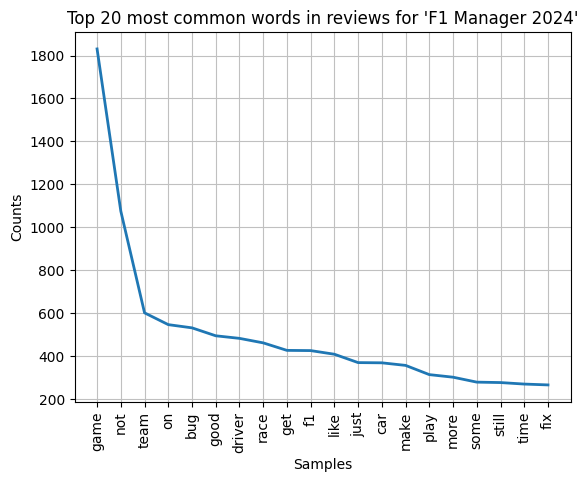

In [ ]:
fd1: FreqDist = td_vector_summary( g1)

Top 20 most common words in reviews for 'Trials Fusion':

 game   not trial  play    on   get  good   fun track  like  just uplay  time   all   buy    no   one great would  make 
 2071  1004   667   616   595   462   413   392   374   344   339   315   302   298   262   262   244   239   239   230 


This top 20 represents 23.40% or 9,668 out of the 41,317 total frequencies.

While 20 words represents 0.45% out of the total 4,457 unique words.

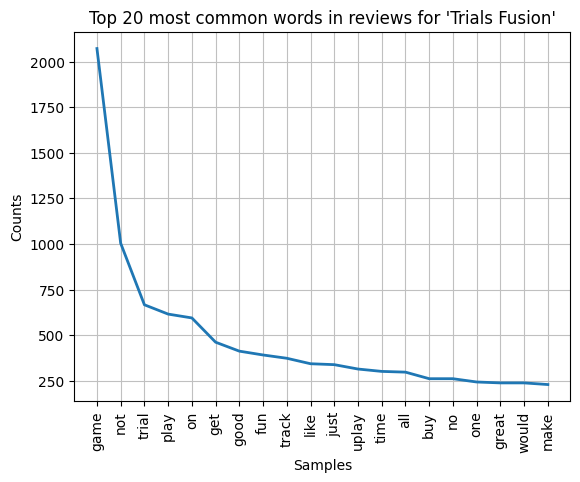

In [143]:
fd2: FreqDist = td_vector_summary(words2, g2)

#### TF Vector and visualization for ngrams

In [142]:
def make_list_ngrams(df: pd.DataFrame) -> list[tuple]:
    ngrams_list: list[tuple] = list()
    for ll in df.ngrams.values:
        for t in ll:
            ngrams_list.append(t)
    return ngrams_list.copy()

In [144]:
ngrm_list1 = make_list_ngrams(df1_rev)
ngrm_list2 = make_list_ngrams(df2_rev)

Top 20 most common words in reviews for 'F1 Manager 2024':

  ('game',)    ('not',)   ('team',)     ('on',)    ('bug',)   ('good',) ('driver',)   ('race',)    ('get',)     ('f1',)   ('like',)   ('just',)    ('car',)   ('make',)   ('play',)   ('more',)   ('some',)  ('still',)   ('time',)    ('fix',) 
       1831        1075         601         546         531         494         482         461         426         425         408         369         368         356         313         301         278         276         269         265 


This top 20 represents 6.80% or 10,075 out of the 148,104 total frequencies.

While 20 words represents 0.02% out of the total 85,210 unique words.

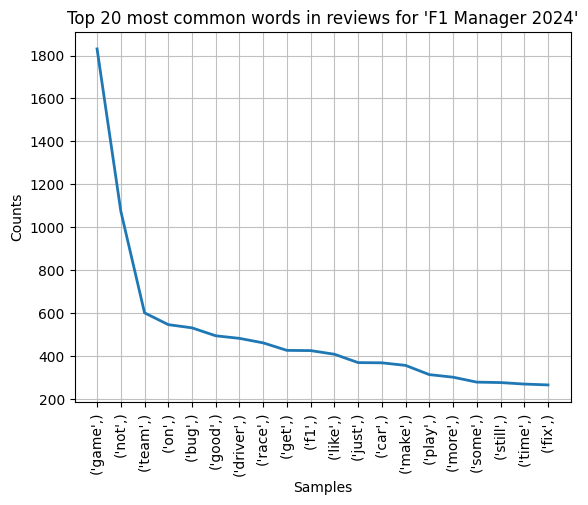

Top 20 most common words in reviews for 'Trials Fusion':

 ('game',)   ('not',) ('trial',)  ('play',)    ('on',)   ('get',)  ('good',)   ('fun',) ('track',)  ('like',)  ('just',) ('uplay',)  ('time',)   ('all',)   ('buy',)    ('no',)   ('one',) ('great',) ('would',)  ('make',) 
      2071       1004        667        616        595        462        413        392        374        344        339        315        302        298        262        262        244        239        239        230 


This top 20 represents 7.54% or 9,668 out of the 128,253 total frequencies.

While 20 words represents 0.03% out of the total 73,743 unique words.

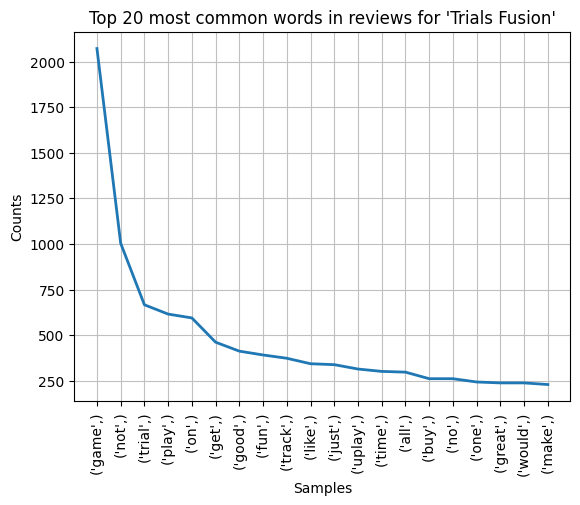

In [148]:
fdn1 = td_vector_summary(ngrm_list1,g1)
fdn2 = td_vector_summary(ngrm_list2,g2)

### TF-IDF Transform and WordCloud

In [272]:
def make_tf_idf(df: pd.DataFrame, n_low: int = 1, n_high: int = 3):
    idf_arg = np.array([" ".join(s) for s in df["words"].values])
    tf_idf =  TfidfVectorizer(ngram_range=(n_low,n_high), smooth_idf=False, strip_accents="unicode")
    X = tf_idf.fit_transform(idf_arg)
    return tf_idf, X

def plot_wordcloud(tf_idf: TfidfVectorizer, bg: str = "black") -> None:
    wc = WordCloud(max_font_size=100, max_words=100, background_color=bg,
                            scale = 10,width=800, height=400).generate(" ".join(tf_idf.vocabulary_.keys()))
    plt.figure(figsize=(15,8))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

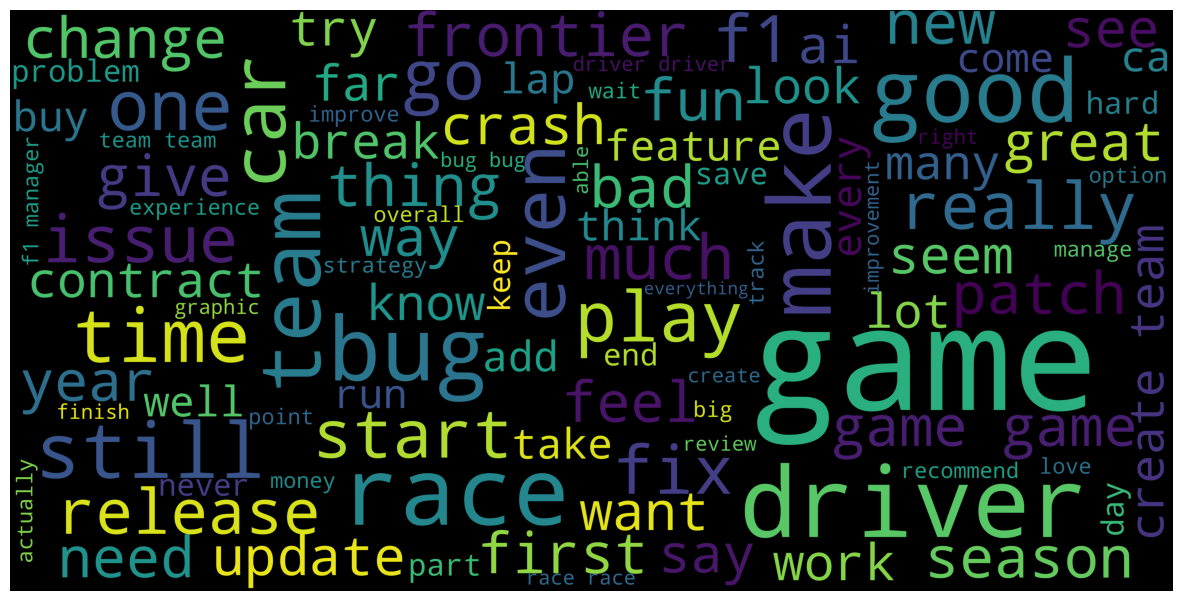

In [273]:
tf_idf1, X1 = make_tf_idf(df1_rev)
plot_wordcloud(tf_idf1)

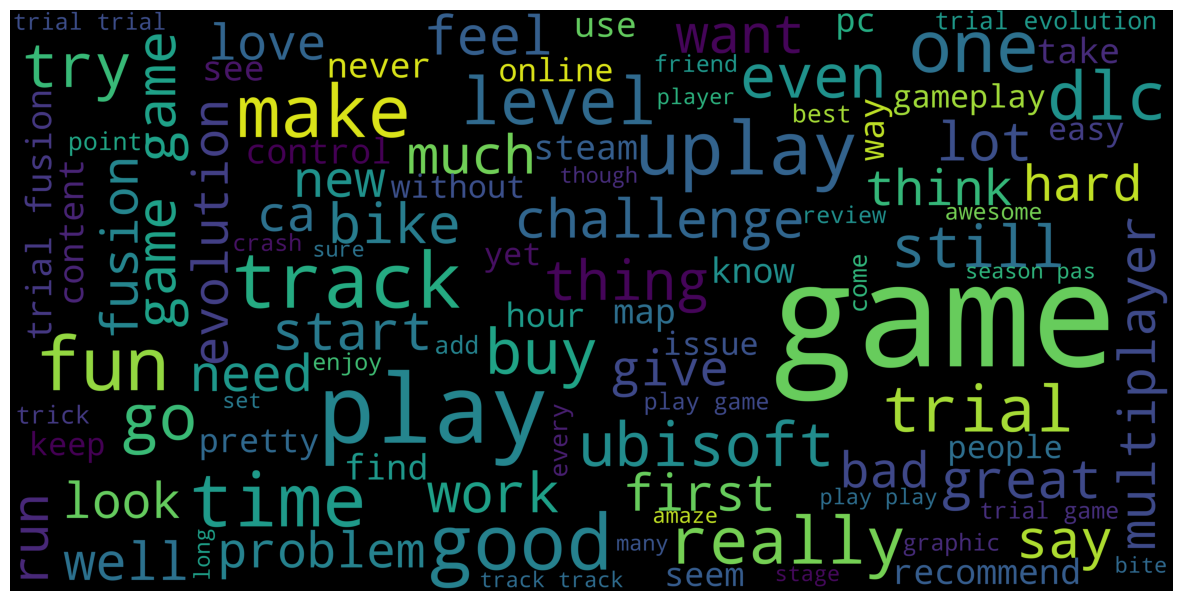

In [274]:
tf_idf2, X2 = make_tf_idf(df2_rev)
plot_wordcloud(tf_idf2)

### Classifier

In [303]:
def classify(df: pd.DataFrame, X, clf):

    y = df["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

    clf.fit(X_train, y_train)
    
    rprint(f"For game: '{df.columns.name}'\n\nBest Model: {clf.best_estimator_}\nBest parameters: {clf.best_params_},\nBest Score: {clf.best_score_:.4f}")

    y_pred = clf.predict(X_test)
    rprint(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title("Confusion Matrix")
    plt.show()
    return clf

c:\Users\Rodrigo\.virtualenvs\ECM514_CD-eIUPckek\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


For game: 'F1 Manager 2024'

Best Model: RandomForestClassifier(max_depth=60, n_estimators=300)
Best parameters: {'max_depth': 60, 'max_features': 'sqrt', 'n_estimators': 300},
Best Score: 0.7499

precision    recall  f1-score   support

    negative       0.90      0.43      0.58       110
    positive       0.75      0.97      0.85       194

    accuracy                           0.78       304
   macro avg       0.83      0.70      0.71       304
weighted avg       0.81      0.78      0.75       304

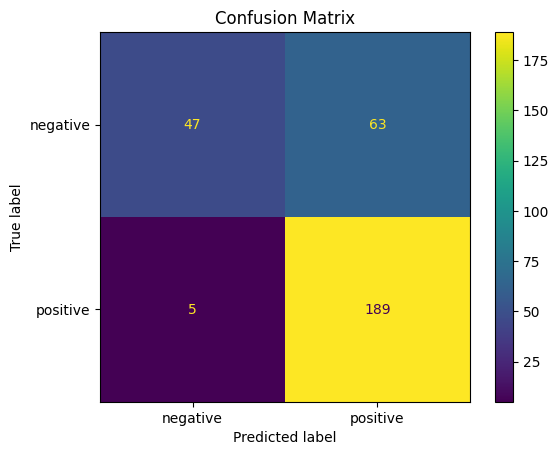

In [306]:
param_grid={
        "n_estimators": [100, 200, 300],
        "max_features": ["sqrt"],
        "max_depth": [30, 40, 50, 60],
    }

gs = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    scoring="f1_weighted",
    cv=5)

# clf = KNeighborsClassifier(n_neighbors=7, metric="cosine")

clf1 = classify(df1_rev, X1, gs)